In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


import sys 
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/pscapes')
sys.path.append('/home/mahakaran/NK-paper-12-5-24-version/nk-ml-paper2-2024/nk-ml-2024')


import numpy as np
import itertools
from sklearn.utils import gen_batches

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from pscapes.landscape_models import make_NK
from pscapes.landscape_class import Protein_Landscape
from pscapes.utils import dict_to_np_array

from src.architectures.testmlp import AminoAcidMLP
from src.architectures.ml_utils import train_model

## Testing MLP

In [4]:
AA_ALPHABET = 'ACDEFG'
SEQ_LENGTH  = 6
K_VALS   = list(range(SEQ_LENGTH))

In [5]:
NK_LANDSCAPES = [make_NK(SEQ_LENGTH, k, AA_ALPHABET, np.random.uniform) for k in K_VALS]

In [6]:
LANDSCAPES = [Protein_Landscape(data=dict_to_np_array(i), amino_acids=AA_ALPHABET) for i in NK_LANDSCAPES]

In [7]:
%%capture

#fit one hot
[i.fit_OHE() for i in LANDSCAPES]

In [8]:
#MLP_params
input_size = SEQ_LENGTH * len(AA_ALPHABET)  # Total input size after flattening
input_size

36

In [9]:
#instantiate models
models     = [AminoAcidMLP(input_size) for i in LANDSCAPES]
loss_fns   = [nn.MSELoss() for i in models]
optimizers = [optim.Adam(i.parameters(), lr=0.001) for i in models]

In [10]:
def get_trainable_params(model): 
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return pytorch_total_params

In [11]:
params = [get_trainable_params(i) for i in models]

In [12]:
params

[13057, 13057, 13057, 13057, 13057, 13057]

In [8]:

batch_size1 = 32

In [9]:
LANDSCAPES[0].fitnesses.shape

(46656,)

In [10]:
LANDSCAPES_OHE = [np.array(i.one_hot_encodings) for i in LANDSCAPES]
LANDSCAPES_OHE_FLATTENED = [i.reshape(i.shape[0], i.shape[1]*i.shape[2]) for i in LANDSCAPES_OHE]


X_OHE = [torch.from_numpy(i).to(torch.float32) for i in LANDSCAPES_OHE_FLATTENED]
Y_OHE = [torch.from_numpy(i.fitnesses.reshape(-1,1).astype(float)).to(torch.float32) for i in LANDSCAPES]

XY_OHE = [list(zip(X_OHE[i], Y_OHE[i])) for i in range(len(X_OHE))]
XY_OHE_TRAIN_TEST_SPLIT = [train_test_split(i, test_size=round(len(i)*0.2)) for i in XY_OHE]

In [13]:
X_TEST = []
Y_TEST = []

for ind, i in enumerate(XY_OHE_TRAIN_TEST_SPLIT):
    
    x_test = []
    y_test = []
    for x, y in XY_OHE_TRAIN_TEST_SPLIT[ind][1]: 
        x_test.append(x.numpy())
        y_test.append(y.numpy())

    x_test = torch.from_numpy(np.array(x_test))
    y_test = torch.from_numpy(np.array(y_test))
    
    X_TEST.append(x_test)
    Y_TEST.append(y_test)

In [14]:
TRAIN_DATALOADER = [DataLoader(i[0], batch_size=batch_size1) for i in XY_OHE_TRAIN_TEST_SPLIT]

In [16]:
# Start training
losses = [train_model(models[i], optimizers[i], loss_fns[i], TRAIN_DATALOADER[i], n_epochs=20, device='cpu') for i in range(len(models))]



Epoch [1/20] Average Loss: 0.0024
Epoch [2/20] Average Loss: 0.0000
Epoch [3/20] Average Loss: 0.0000
Epoch [4/20] Average Loss: 0.0000
Epoch [5/20] Average Loss: 0.0000
Epoch [6/20] Average Loss: 0.0000
Epoch [7/20] Average Loss: 0.0000
Epoch [8/20] Average Loss: 0.0000
Epoch [9/20] Average Loss: 0.0000
Epoch [10/20] Average Loss: 0.0000
Epoch [11/20] Average Loss: 0.0000
Epoch [12/20] Average Loss: 0.0000
Epoch [13/20] Average Loss: 0.0000
Epoch [14/20] Average Loss: 0.0000
Epoch [15/20] Average Loss: 0.0000
Epoch [16/20] Average Loss: 0.0000
Epoch [17/20] Average Loss: 0.0000
Epoch [18/20] Average Loss: 0.0000
Epoch [19/20] Average Loss: 0.0000
Epoch [20/20] Average Loss: 0.0000
Training completed
Epoch [1/20] Average Loss: 0.0062
Epoch [2/20] Average Loss: 0.0005
Epoch [3/20] Average Loss: 0.0003
Epoch [4/20] Average Loss: 0.0002
Epoch [5/20] Average Loss: 0.0002
Epoch [6/20] Average Loss: 0.0001
Epoch [7/20] Average Loss: 0.0001
Epoch [8/20] Average Loss: 0.0001
Epoch [9/20] Avera

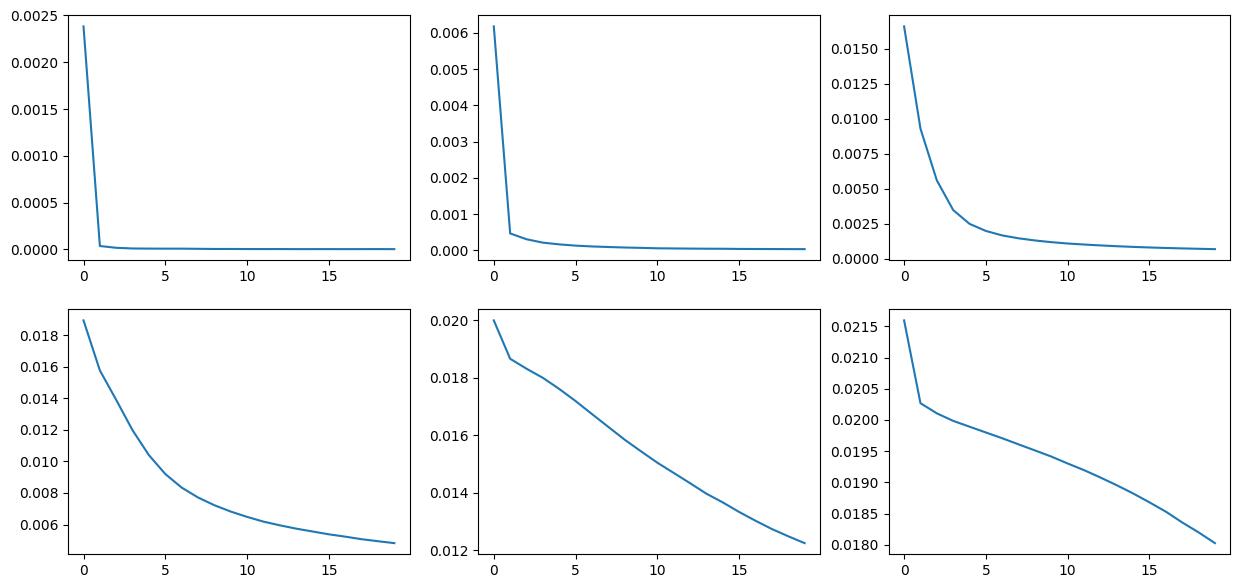

In [38]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].plot(losses[0])
ax[0,1].plot(losses[1])
ax[0,2].plot(losses[2])
ax[1,0].plot(losses[3])
ax[1,1].plot(losses[4])
ax[1,2].plot(losses[5])




#for i in ax.flatten():
    #i.set_ylim(0,0.01)

In [217]:
mean_squared_error(y_pred.detach(), Y_TEST.detach())

0.0006863425

In [44]:
TEST_PREDS = [models[i](X_TEST[i]).detach() for i in range(len(models))]

In [58]:
r2_losses = [r2_score(TEST_PREDS[i].detach(), Y_TEST[i].detach()) for i in range(len(TEST_PREDS))]

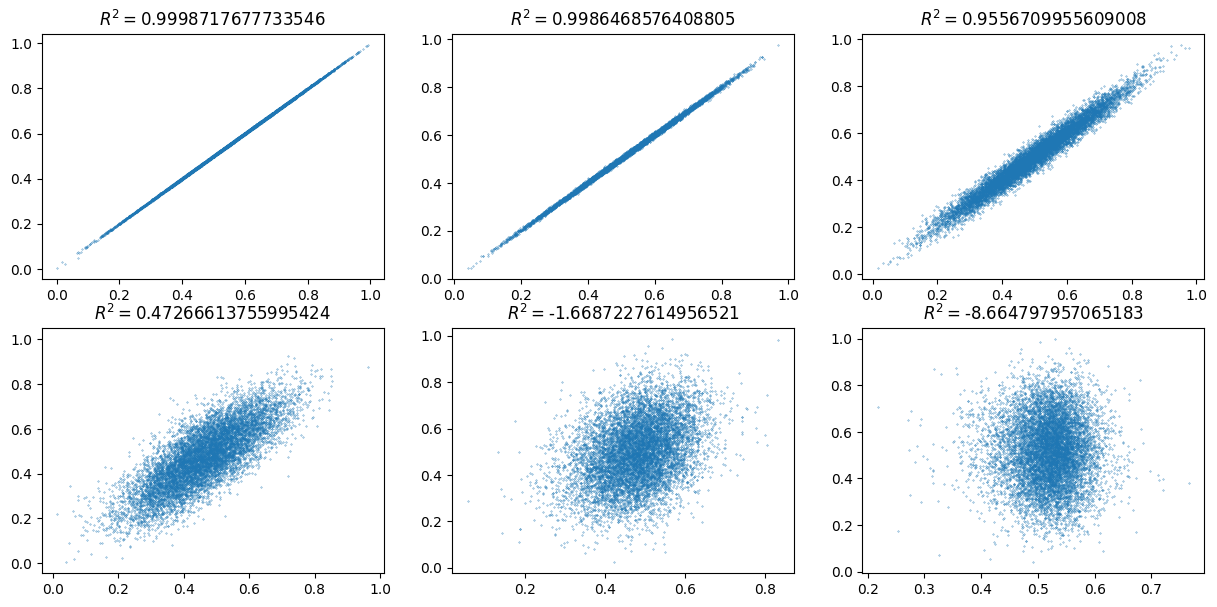

In [65]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
ax[0,0].scatter(TEST_PREDS[0], Y_TEST[0],marker='.', s=.3)
ax[0,1].scatter(TEST_PREDS[1], Y_TEST[1],marker='.', s=.3)
ax[0,2].scatter(TEST_PREDS[2], Y_TEST[2],marker='.', s=.3)
ax[1,0].scatter(TEST_PREDS[3], Y_TEST[3],marker='.', s=.3)
ax[1,1].scatter(TEST_PREDS[4], Y_TEST[4],marker='.', s=.3)
ax[1,2].scatter(TEST_PREDS[5], Y_TEST[5],marker='.', s=.3)



for ind, i in enumerate(ax.flatten()):
    i.set_title("$R^2 = $" + str(r2_losses[ind]))
    
